# Retrain a Tensor Classifier
The following script will demonstrate how easy it is retrain an existing convolutional neural network. In particular we will working with MobileNet in order to have it work on a light weight system like a Rasberry Pi. 

There are a few things that make MobileNets awesome:
- They’re extremely small
- They’re insanely fast
- They’re remarkably accurate
- They’re easy to tune for resources vs. accuracy

MobileNets surface two parameters that we can tune to fit the resource/accuracy trade-off of our exact problem: width multiplier and resolution multiplier. The width multiplier allows us to thin the network, while the resolution multiplier changes the input dimensions of the image, reducing the internal representation at every layer.

The architecture flag is where we tell the retraining script which version of MobileNet we want to use. The 1.0 corresponds to the width multiplier, and can be 1.0, 0.75, 0.50 or 0.25. The 224 corresponds to image resolution, and can be 224, 192, 160 or 128. For example, to train the smallest version, you’d use `--architecture mobilenet_0.25_128`. Here we want a model with better accuracy evey if it is larger. So we chose 1.0 and 224.

We also have to give the model labeled examples of images we would like to classify. Luckily this is extremely easy. I created a folder called "StreetCapture" and within it are a series of folders, the names of which act as labels. I then placed example images into each folder label. So for example in the "1car" folder I placed about 100 examples of photos with one car, while any images with FedEx trucks were placed into a FedEx folder. This folder is then passed the the `retrain` function below as the `RETRAIN_IMAGES` parameter.

For example, the `--learning_rate` parameter controls the magnitude of the updates to the final layer during training. So far we have left it out, so the program has used the default learning_rate value of 0.01. If you specify a small learning_rate, like 0.005, the training will take longer, but the overall precision might increase. Higher values of learning_rate, like 1.0, could train faster, but typically reduces precision, or even makes training unstable.


Here is an screenshot of my "labels" ie folders:

<img src='images/FolderStructure2.png' width='50%'>
*Note: Folder names cannot start with numbers or special characters* 



Before we can classify new images however we need to retrain the old classifier to identify new image labels. This is done by what is called transfer learning. 

In this case I retrain the classifier by running the following in the Bash command line:



In [ ]:
# run following in shell (bash) before running the following script. 
git clone https://github.com/googlecodelabs/tensorflow-for-poets-2.git
cd ~/Documents/tensorflow-for-poets-2/
source activate tensorflow   # activate anaconda environment with tensorflow
IMAGE_SIZE=224
ARCHITECTURE="mobilenet_1.0_${IMAGE_SIZE}"
# update the --image_dir flag to your folder with training photos "/home/mmann1123/Dropbox/PiCapture/StreetCapture"
python -m scripts.retrain   --bottleneck_dir=tf_files/bottlenecks   --how_many_training_steps=500   --model_dir=tf_files/models/   --summaries_dir=tf_files/training_summaries/"${ARCHITECTURE}"   --output_graph=tf_files/retrained_graph_"${ARCHITECTURE}".pb   --output_labels=tf_files/retrained_labels_"${ARCHITECTURE}".txt   --architecture="${ARCHITECTURE}" --learning_rate=0.0005 --summaries_dir=tf_files/training_summaries/"${ARCHITECTURE}"_LR_0005 --image_dir="/home/mmann1123/Dropbox/PiCapture/StreetCapture"

# Classify a batch of new images

In this section we will apply our retrained algorithm to a new set of images. 

In [1]:
# run from python
%matplotlib inline
import scripts.label_image
import sys
import numpy as np
import tensorflow as tf
import os, glob
import matplotlib.pyplot as plt


## Show test images

In [2]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

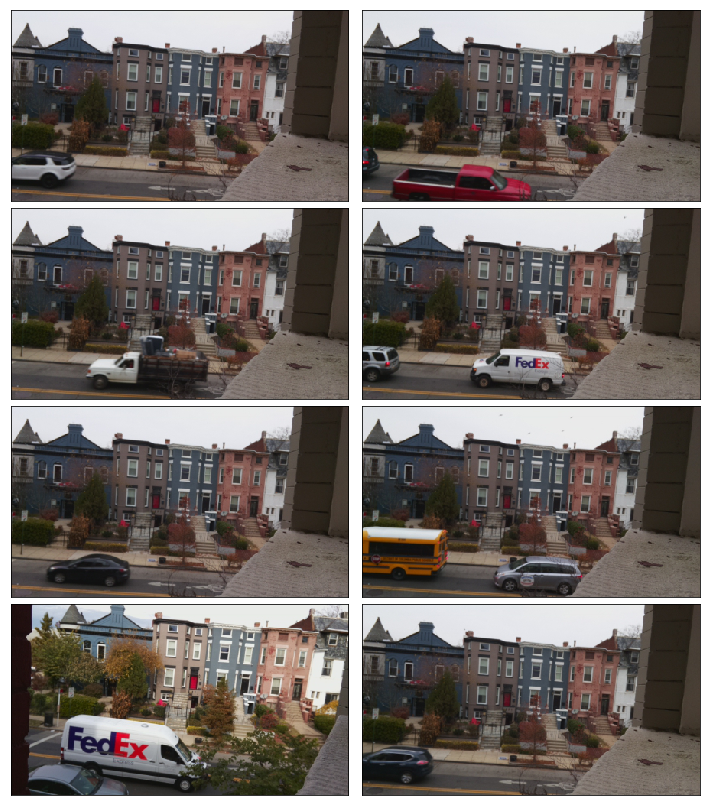

In [3]:
test_images = [plt.imread(path) for path in 
                   glob.glob('/home/mmann1123/Dropbox/PiCapture/Testing/*.jpg')]


show_images(test_images)

In [4]:
# Load slightly edited TensorFlow functions

def load_graph(model_file):
  graph = tf.Graph()
  graph_def = tf.GraphDef()
  with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
  with graph.as_default():
    tf.import_graph_def(graph_def)
  return graph


def read_tensor_from_image_file(file_name, input_height=299, input_width=299, input_mean=0, input_std=255):
  input_name = "file_reader"
  output_name = "normalized"
  file_reader = tf.read_file(file_name, input_name)
  if file_name.endswith(".png"):
    image_reader = tf.image.decode_png(file_reader, channels = 3,
                                       name='png_reader')
  elif file_name.endswith(".gif"):
    image_reader = tf.squeeze(tf.image.decode_gif(file_reader,
                                                  name='gif_reader'))
  elif file_name.endswith(".bmp"):
    image_reader = tf.image.decode_bmp(file_reader, name='bmp_reader')
  else:
    image_reader = tf.image.decode_jpeg(file_reader, channels = 3,
                                        name='jpeg_reader')
  float_caster = tf.cast(image_reader, tf.float32)
  dims_expander = tf.expand_dims(float_caster, 0);
  resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
  normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
  sess = tf.Session()
  result = sess.run(normalized)
  return result

def load_labels(label_file):
  label = []
  proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
  for l in proto_as_ascii_lines:
    label.append(l.rstrip())
  return label


Two additional parameters are used to normalize the dataset, as we observe improvement in the result of doing so. The `input_mean`, is the mean per channel of the dataset, and the `input_std` is the standard deviation associated.  

In [5]:
# Set basic image parameters
image_size = 224
input_height = image_size
input_width = image_size
input_mean =  128
input_std =  128
input_layer = "input"
output_layer = "final_result"
label_file = r'/home/mmann1123/Documents/tensorflow-for-poets-2/tf_files/retrained_labels.txt'
model_file = r'/home/mmann1123/Documents/tensorflow-for-poets-2/tf_files/retrained_graph.pb'


In [38]:
str(random.randint(1,100))

'67'

In [39]:
# iterate across series of photos 
import os
from PIL import Image, ImageDraw, ImageFont
import time
import psutil
import random
testing_dir = r'/home/mmann1123/Dropbox/PiCapture/Testing/'
out_dir = r'/home/mmann1123/Dropbox/PiCapture/Classified/'
#os.chdir(r'/home/mmann1123/Dropbox/PiCapture/Testing')
#rootdir = os.getcwd()
tff ='/home/mmann1123/Documents/Fonts/unifont-10.0.07.ttf' # font files can be downloaded here http://unifoundry.com/unifont.html

#import warnings
#warnings.filterwarnings('ignore')

# walk all directories and apply classification 
for dir, dirs, files in os.walk(testing_dir):
    for file in files:
    	file_name = os.path.join(dir, file)
	print(file_name)
	graph = load_graph(model_file)
	t = read_tensor_from_image_file(file_name,input_height=input_height,input_width=input_width,input_mean=input_mean,input_std=input_std)
	input_name = "import/" + input_layer
	output_name = "import/" + output_layer
	input_operation = graph.get_operation_by_name(input_name)
	output_operation = graph.get_operation_by_name(output_name)
	with tf.Session(graph=graph) as sess:
	   results = sess.run(output_operation.outputs[0],
		  {input_operation.outputs[0]: t})
	results = np.squeeze(results)
	top_k = results.argsort()[-5:][::-1]
	labels = load_labels(label_file)
	print(labels[top_k[0]], results[top_k[0]])
	image = Image.open( file_name)
	font_type = ImageFont.truetype(tff,35) 
	draw = ImageDraw.Draw(image)    
	draw.text(xy =(50,50),text=labels[top_k[0]]+' '+np.array2string(results[top_k[0]])[0:4],fill=(255,255,255), font=font_type)
	image.save(out_dir+labels[top_k[0]]+np.array2string(results[top_k[0]])[0:4]+'_'+str(random.randint(1,100))+'.png')
	image.show()
  #  time.sleep(1)

    
    # hide image
	for proc in psutil.process_iter():
		if proc.name() == "display":
			proc.kill()

/home/mmann1123/Dropbox/PiCapture/Testing/Picapture_08_12_2017-14:58:14.jpg
('largecar', 0.90614206)
/home/mmann1123/Dropbox/PiCapture/Testing/Picapture_08_12_2017-14:54:02.jpg
('largecar', 0.8161875)
/home/mmann1123/Dropbox/PiCapture/Testing/Picapture_08_12_2017-14:58:02.jpg
('largecar', 0.82517862)
/home/mmann1123/Dropbox/PiCapture/Testing/Picapture_08_12_2017-14:56:00.jpg
('fedex', 0.99648786)
/home/mmann1123/Dropbox/PiCapture/Testing/Picapture_08_12_2017-14:58:05.jpg
('largecar', 0.37629563)
/home/mmann1123/Dropbox/PiCapture/Testing/Picapture_08_12_2017-14:52:00.jpg
('fedex', 0.56462747)
/home/mmann1123/Dropbox/PiCapture/Testing/Picapture_08_12_2017-14:52:20.jpg
('fedex', 0.99942636)
/home/mmann1123/Dropbox/PiCapture/Testing/Picapture_08_12_2017-14:58:09.jpg
('largecar', 0.47785249)


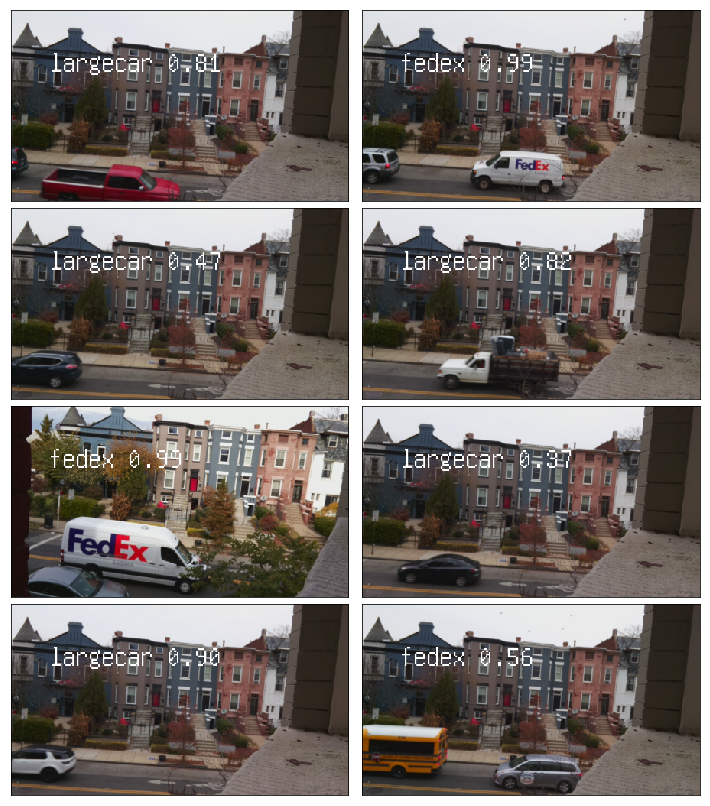

In [42]:
%matplotlib inline
test_images = [plt.imread(path) for path in 
                   glob.glob('/home/mmann1123/Dropbox/PiCapture/Classified/*.png')]


show_images(test_images)

Although the classifier is confusing some large cars and vans, it does quite well with our primary classification of interest, FedEx trucks. Although some more testing needs to be done this is encouraging. 